In [1]:
%%HTML
<style>
	@import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

	body {
		font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
		line-height: 1.67;
	}
</style>

# Dynamic Periodic ETC for LPV Models under Saturation

_**[Event-based Control](https://github.com/andel-vitorio/event-based-control.git)**_

_by Andevaldo da Encarnação Vitório ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br)), last updated: April 20, 2025_

<!-- This notebook presents the implementation of the mathematical modeling and controller for a DC microgrid, represented by a buck converter with a CPL (Constant Power Load). The buck converter is a power conversion device that steps down a high DC voltage to a lower one. The CPL is a load that demands constant power regardless of variations in input voltage.

For the implementation, Python libraries such as Control, NumPy, and Matplotlib will be used. During implementation, the nonlinear system, shifted nonlinear system, and linearized system, all derived from the mathematical modeling, will be explored. -->

<!-- Detailed mathematical modeling can be found in the separate document titled ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), located in the `docs` directory.  -->

## 1. Importing Libraries

In [2]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os
import json

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset




# Import utility functions from custom modules
import Utils.Tex as tex
import Utils.Graphs as gph
import Utils.Signal as sgn
import Utils.Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


## 2. LPV Model

In [3]:
def get_A(params):
  Rco = params['Rco']
  Rw = params['Rw']
  Rci = params['Rci']
  Rv = params['Rv']
  Cw = params['Cw']
  Ca = params['Ca']

  A11 = - (Rco + Rw + Rci) / (Cw * (Rco + (Rw / 2.)) * (Rci + (Rw / 2.)))
  A12 = 1.0 / (Cw * (Rci + (Rw / 2.)))
  A21 = 1.0 / (Ca * (Rci + (Rw / 2.)))
  A22 = - (Rci + (Rw / 2.) + Rv) / (Ca * Rv * (Rci + (Rw / 2.)))

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(params):
  Ca = params['Ca']
  B11 = 0
  B21 = 1 / Ca
  return np.array([[B11],
                   [B21]])


def get_C(p):
  return np.array([[0.0, 1.0]])


def get_E(params):
  Rco = params['Rco']
  Rw = params['Rw']
  Rci = params['Rci']
  Rv = params['Ca']
  Cw = params['Cw']
  Ca = params['Ca']

  E11 = - (Rco + Rw + Rci) / (Cw * (Rco + (Rw / 2.)) * (Rci + (Rw / 2.)))
  E12 = 1.0 / (Cw * (Rci + (Rw / 2.)))
  E21 = 1.0 / (Ca * (Rci + (Rw / 2.)))
  E22 = - (Rci + (Rw / 2.) + Rv) / (Ca * Rv * (Rci + (Rw / 2.)))

  return np.array([[E11, E12],
                   [E21, E22]])


def plant_update(time, states, inputs, params):
  A = get_A(params)
  B = get_B(params)
  E = get_E(params)

  x = states.reshape(-1, 1)
  u = inputs[0:1].reshape(-1, 1)
  w = inputs[1:3].reshape(-1, 1)

  # Computing the time derivative of the states (x_dot)
  x_dot = A @ x + B @ u + E @ w

  return x_dot


# Assuming control library's nlsys function is used here
plant = ct.nlsys(plant_update, None, name="plant",
                 inputs=('Qg', 'θ0', 'Qs'), outputs=('Θw', 'Θz'),
                 states=('Θw', 'Θz'))

# Printing the plant system
print(plant)

<NonlinearIOSystem>: plant
Inputs (3): ['Qg', 'θ0', 'Qs']
Outputs (2): ['Θw', 'Θz']
States (2): ['Θw', 'Θz']

Update: <function plant_update at 0x70c49e1c91c0>
Output: None


## Predefinição da Simulação

In [4]:
import numpy as np


def piecewise_linear(timepts, points):
  """
  Generate a piecewise linear function defined by (time, value) pairs.

  Parameters
  ----------
  timepts : array_like
      Array of time points where the function should be evaluated.
  points : list of tuple
      List of (time, value) pairs defining the piecewise linear function.

  Returns
  -------
  values : np.ndarray
      Array of function values at the given timepts.
  """
  timepts = np.asarray(timepts)
  points = sorted(points)  # Ensure the points are sorted by time

  # Unzip times and values
  times, values = zip(*points)

  # Use numpy interpolation (linear by default)
  return np.interp(timepts, times, values, left=0.0, right=0.0)

In [26]:
simulation_step = 1e-3
simulation_time = 250
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Input for open-loop simulation
Qg = np.zeros((1, len(timepts)))

# Energy limits
energy_bound = 100

Θ0_points = [(10, 0), (12, 15), (16, 25), (20, 47.5), (25, 50.0),
             (30, 15.0), (35, 12.5), (38, 20.0), (40, 0), (90, 0), (91, 10.0),
             (95, 9.0), (100, 4.0), (105, 7.0), (110, 5.6)]
θ0 = piecewise_linear(timepts, Θ0_points)

Qs_points = [(0, 0), (5, -0.75), (15, -1.5), (20, -1.75), (25, -2),
             (30, -1.75), (35, -0.60), (42, 3.25), (43, 4.25), (45, 4.5),
             (48, 4.35), (53, 3.75), (60, 3), (80, 1.75),
             (90, -0.5), (92, -0.25), (94, 0.25), (100, 0.15), (110, 0)]
Qs = piecewise_linear(timepts, Qs_points)

# θ0 = np.zeros((1, len(timepts)))
# Qs = np.zeros((1, len(timepts)))

θ0 = θ0 * 0.5
Qs = Qs * 0.5

integral_w_norm = np.sum(θ0 ** 2 + Qs ** 2) * (timepts[1] - timepts[0])
print('∫|w(t)|dt = ', integral_w_norm)

x_bounds = [(-10, 10.), (-10., 10.)]

params = {
    'Rco': 0.014e-3,   # 10% of the original value
    'Rw': 0.19e-3,     # 10%
    'Rci': 0.037e-3,   # 10%
    'Rv': 0.14e-3,     # 10%
    'Cw': .4e6,       # 1%
    'Ca': 7.2e4       # 1%
}

# params = {
#     'Rco': 0.014e-3,   # 10% of the original value
#     'Rw': 1.9e-3,     # 10%
#     'Rci': 0.037e-3,   # 10%
#     'Rv': 1.4e-3,     # 10%
#     'Cw': 40e6,       # 1%
#     'Ca': 72e4       # 1%
# }


X0 = [.5, .5]

fig = plt.figure(figsize=(6, 6), layout='constrained')
axs = fig.subplot_mosaic([["θ0"], ["Qs"]])

plot_cfg = {
    'style': {
        'color': 'black'
    },
    'limits': {
        'x_min': timepts[0],
        'x_max': timepts[-1],
    },
    'axis': {
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'x_digits': 0,
        'y_digits': 0,
    }
}

gph.plot(axs['θ0'], timepts, θ0,
         xlabel='$t$ (s)', ylabel=r'$\theta_0$ [$W/m^2$]',
         title='Solar Radiation', plot_cfg=plot_cfg)

gph.plot(axs['Qs'], timepts, Qs,
         xlabel='$t$ (s)', ylabel='$Q_s$ [ºC]',
         title='External Temperature', plot_cfg=plot_cfg)

plt.tight_layout()
params

∫|w(t)|dt =  7091.340205094934


{'Rco': 1.4e-05,
 'Rw': 0.00019,
 'Rci': 3.7e-05,
 'Rv': 0.00014,
 'Cw': 400000.0,
 'Ca': 72000.0}

## Simulação da Planta em Malha Aberta

In [6]:
t, y = ct.input_output_response(
    sys=plant, T=timepts,
    U=[Qg, θ0, Qs],
    X0=X0, params=params
)

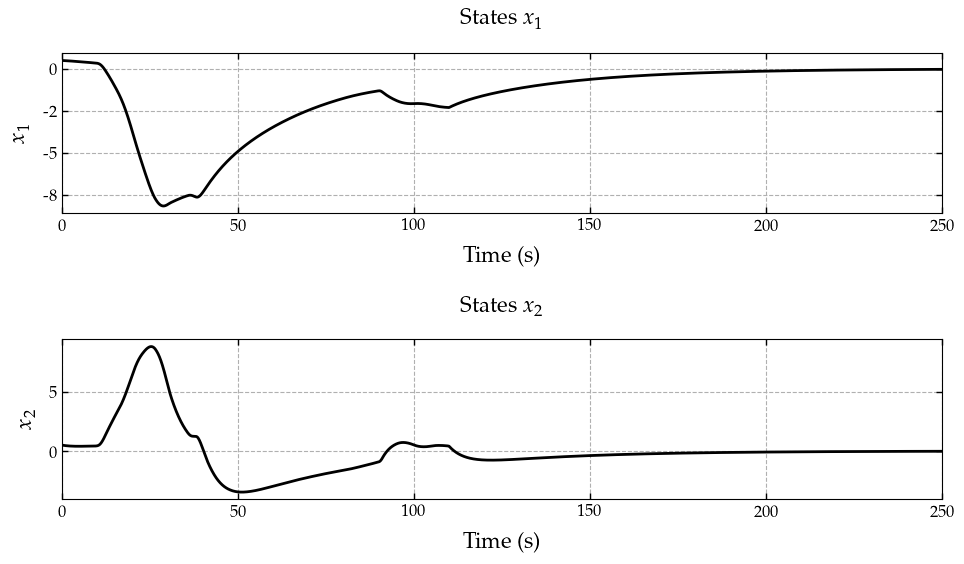

In [7]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
axs = fig.subplot_mosaic([["x1"], ["x2"]])

plot_cfg = {
    'style': {
        'color': 'black'
    },
    'limits': {
        'x_min': t[0],
        'x_max': t[-1],
    },
    'axis': {
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'x_digits': 0,
        'y_digits': 0,
    }
}

for i in [0, 1]:
  gph.plot(axs[f'x{i+1}'], t, y[i],
           xlabel='Time (s)', ylabel=f'$x_{i+1}$',
           title=f'States $x_{i+1}$', plot_cfg=plot_cfg)
plt.tight_layout(pad=2.)

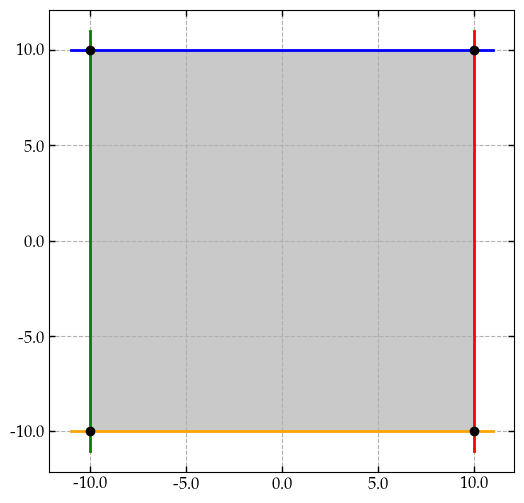

In [8]:
a_q = nm.get_vertices(x_bounds)
plot_data = nm.get_polyhedral_set(a_q, x_bounds)

# === Visualização do resultado ===

fig, ax = plt.subplots(figsize=(6, 6))
colors = ['red', 'green', 'blue', 'orange']

# Plot lines
for i, (x_vals, y_vals) in enumerate(plot_data["line_segments"]):
  gph.plot(ax, x_vals, y_vals, plot_cfg={'style': {'color': colors[i]}})

# Plot polygon (if it exists)
if plot_data["polygon_coords"] is not None:
  poly = plot_data["polygon_coords"]
  ax.fill(*poly.T, alpha=0.21, color='black', label="Intersection region")

# Plot intersection points
if plot_data["intersection_points"].size > 0:
  ax.scatter(*plot_data["intersection_points"].T, color='black', zorder=5)

In [9]:
def He(M): return M + M.T


def get_parameter(params, h, λ, delta, epsilon_bounds, eps=1e-6):

  n_u = 1
  n_x = 2
  n_w = 2
  n_z = 1

  Onx = np.zeros((n_x, n_x))
  O2nx = np.zeros((2 * n_x, 2 * n_x))

  aq = nm.get_vertices(x_bounds)

  A = get_A(params)
  B = get_B(params)
  C = get_C(params)
  E = get_E(params)

  e = {}
  _es = np.eye(n_x)
  _ef = np.zeros((n_x, 6 * n_x))
  e[1] = np.block([[_es, _ef, np.zeros((n_x, n_w))]])
  e[7] = np.block([[_ef, _es, np.zeros((n_x, n_w))]])

  for i in range(2, 7):
    e[i] = np.block([[np.zeros((n_x, n_x * (i - 1))),
                      np.eye(n_x),
                      np.zeros((n_x, n_x * (7 - i))),
                      np.zeros((n_x, n_w))]])

  e[8] = np.block(
      [[np.zeros((n_w,  7 * n_x)), np.eye(n_w)]])

  for i in range(1, 9):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Stil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((n_x, n_x))

  Pcal = cp.bmat([[Ptil,   Mtil],
                  [Mtil.T, Stil]])

  constraints = []

  Ktil = cp.Variable((n_u, n_x), name=f'K')

  Qtil = cp.Variable((n_x, n_x), PSD=True)
  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)
  β = cp.Variable(pos=True)
  ρ = cp.Variable(pos=True)
  μ = cp.Variable(pos=True)
  γ = cp.Variable(pos=True)
  δ = cp.Parameter(pos=True, value=delta)

  X = cp.Variable((n_x, n_x))
  Y1til = cp.Variable((2 * n_x, 2 * n_x))
  Y2til = cp.Variable((2 * n_x, 2 * n_x))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  N = e[1].T + λ * e[2].T + λ * e[3].T

  Π = cp.bmat([[e[1] - e[3]],
              [e[1] + e[3] - 2 * e[5]],
              [e[3] - e[4]],
              [e[3] + e[4] - 2 * e[6]]])

  κ1 = {}
  κ1['0'] = cp.bmat([[e[1]], [h * e[6]]])
  κ1['h'] = cp.bmat([[e[1]], [h * e[5]]])

  κ2 = cp.bmat([[e[2]], [e[1] - e[4]]])

  def get_Λ():
    Ytil = A @ X @ e[1] - X @ e[2] + \
        B @ Ktil @ e[3] + B @ Ktil @ e[7] + γ * E @ e[8]

    Φtil = {}

    Φtil1 = cp.bmat([[Rcal, O2nx],
                    [O2nx, Rcal]])
    Φtil2 = cp.bmat([[Rcal, Y2til], [Y2til.T, O2nx]])
    Φtil3 = cp.bmat([[O2nx, Y1til], [Y1til.T, Rcal]])

    Φtil['0'] = Φtil1 + Φtil2
    Φtil['h'] = Φtil1 + Φtil3

    Θtil = {}
    Θtil['0'] = 2 * κ1['0'].T @ Pcal @ κ2 + e[1].T @ Qtil @ e[1] - \
        e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + He(N @ Ytil) - γ * \
        e[8].T @ e[8] - Π.T @ Φtil['0'] @ Π

    Θtil['h'] = 2 * κ1['h'].T @ Pcal @ κ2 + e[1].T @ Qtil @ e[1] - \
        e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + He(N @ Ytil) - γ * \
        e[8].T @ e[8] - Π.T @ Φtil['h'] @ Π

    Γ1_11 = Θtil['0'] - Π.T @ Φtil['0'] @ Π
    Γ1_12 = Π.T @ cp.bmat([[Y1til], [O2nx]])
    Γ1_13 = e[3].T @ X.T
    Γ1_14 = e[1].T @ X.T @ C.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Rcal
    Γ1_23 = np.zeros((2 * n_x, n_x))
    Γ1_24 = np.zeros((2 * n_x, n_z))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - Ψtil
    Γ1_34 = np.zeros((n_x, n_z))

    Γ1_41 = Γ1_14.T
    Γ1_42 = Γ1_24.T
    Γ1_43 = Γ1_34.T
    Γ1_44 = - np.eye(n_z)

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13, Γ1_14],
                  [Γ1_21, Γ1_22, Γ1_23, Γ1_24],
                  [Γ1_31, Γ1_32, Γ1_33, Γ1_34],
                  [Γ1_41, Γ1_42, Γ1_43, Γ1_44]])

    Γ2_11 = Θtil['h'] - Π.T @ Φtil['h'] @ Π
    Γ2_12 = Π.T @ cp.bmat([[O2nx], [Y2til.T]])
    Γ2_13 = e[3].T @ X.T
    Γ2_14 = e[1].T @ X.T @ C.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))
    Γ2_24 = np.zeros((2 * n_x, n_z))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil
    Γ2_34 = np.zeros((n_x, n_z))

    Γ2_41 = Γ2_14.T
    Γ2_42 = Γ2_24.T
    Γ2_43 = Γ2_34.T
    Γ2_44 = - np.eye(n_z)

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13, Γ2_14],
                  [Γ2_21, Γ2_22, Γ2_23, Γ2_24],
                  [Γ2_31, Γ2_32, Γ2_33, Γ2_34],
                  [Γ2_41, Γ2_42, Γ2_43, Γ2_44]])

    return Γ1, Γ2

  Λ = {}
  Λ['0'], Λ['h'] = get_Λ()
  constraints += [Λ['0'] << -eps * np.eye(Λ['0'].shape[0])]
  constraints += [Λ['h'] << -eps * np.eye(Λ['h'].shape[0])]

  # for i in range(4):
  #   LMI_INC_DX_11 = Ptil + (h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T)
  #   LMI_INC_DX_12 = aq[i]
  #   LMI_INC_DX_13 = aq[i]

  #   LMI_INC_DX_21 = LMI_INC_DX_12.T
  #   LMI_INC_DX_22 = β * np.eye(1)
  #   LMI_INC_DX_23 = np.zeros((1, 1))

  #   LMI_INC_DX_31 = LMI_INC_DX_13.T
  #   LMI_INC_DX_32 = LMI_INC_DX_23.T
  #   LMI_INC_DX_33 = γ * δ * np.eye(1)

  #   LMI_INC_DX = cp.bmat([[LMI_INC_DX_11, LMI_INC_DX_12, LMI_INC_DX_13],
  #                         [LMI_INC_DX_21, LMI_INC_DX_22, LMI_INC_DX_23],
  #                         [LMI_INC_DX_31, LMI_INC_DX_32, LMI_INC_DX_33]])

  #   constraints += [LMI_INC_DX >> 0.]

  # for i in range(4):
  #   LMI_INC_11 = μ * np.eye(1)
  #   LMI_INC_12 = ρ * aq[i].T
  #   LMI_INC_21 = LMI_INC_12.T
  #   LMI_INC_22 = X.T + X - Ptil

  #   LMI_INC = cp.bmat([[LMI_INC_11,   LMI_INC_12],
  #                      [LMI_INC_21,  LMI_INC_22]])
  # constraints += [LMI_INC >> 0.]

  constraints += [Pcal >> eps * np.eye(Pcal.shape[0])]
  # constraints += [(h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T) << 0.]
  constraints += [γ >= epsilon_bounds[0]]
  # constraints += [ρ >= epsilon_bounds[1]]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil))
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)

    # matrix_utils.show_matrix(Xinv.T @ Ξtil.value)

    # matrix_utils.show_matrix(X.value, 'X')

    P = Xinv.T @ Ptil.value @ Xinv
    M = Xinv.T @ Mtil.value @ Xinv
    S = Xinv.T @ Stil.value @ Xinv
    Q = Xinv.T @ Qtil.value @ Xinv
    R = Xinv.T @ Rtil.value @ Xinv

    Pcal_ = np.block([[P, M], [M.T, S]])

    # matrix_utils.show_matrix(Ptil.value, 'Ptil')

    P_eig = np.linalg.eig(P)[0]
    S_eig = np.linalg.eig(S)[0]
    Pcal_eig = np.linalg.eig(Pcal_)[0]

    error = False

    # for i in range(n_x):
    #   if P_eig <= 0:
    #     # print("P não é definida positiva!")
    #     error = True
    #   if S_eig <= 0:
    #     # print("S não é definida positiva!")
    #     error = True

    # # print('Autovalores de Pcal: ', Pcal_eig)
    # for eig in Pcal_eig:
    #   if eig <= 0:
    #     # print("Pcal não é definida positiva!")
    #     error = True

    if error == False:
      K = Ktil.value @ Xinv
      # matrix_utils.show_matrix(K, f'K{i}')

      # matrix_utils.show_matrix(Ξ, 'Ξ')
      # matrix_utils.show_matrix(Ψ, 'Ψ')

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ},
          'controller': {'K': K},
          'lyapunov': {'P': P, 'M': M, 'S': S, 'Q': Q, 'R': R},
          'bounds': {'β': β.value, 'ρ': ρ.value, 'γ': γ.value}
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [11]:
%%skip

# Definir a escala logarítmica dos parâmetros
ε1_values = np.logspace(-3, 3, num=1000)  # Epsilon de γ
ε2_values = np.logspace(-3, 3, num=1)  # Epsilon de ρ

δ = 1e-4
h = 0.1
λ = 1e-2

# Lista para armazenar os resultados
opt_prob_results = []

# Função para executar no pool de processos


def evaluate_parameters(args):
  ε1, ε2 = args
  try:
    epsilon_bounds = [ε1, ε2]
    design_results = get_parameter(h=h, λ=λ, delta=δ, params=params,
                                   epsilon_bounds=epsilon_bounds)
    if design_results is not None:
      bounds = design_results['bounds']
      return (bounds['γ'], bounds['ρ'], bounds['β'], design_results['optimal_value'])
  except:
    pass
  return None


# Criando a lista de combinações dos parâmetros
param_combinations = [(ε1, ε2) for ε1 in ε1_values for ε2 in ε2_values]

# Executando em paralelo
with concurrent.futures.ProcessPoolExecutor() as executor:
  for result in executor.map(evaluate_parameters, param_combinations):
    if result is not None:
      opt_prob_results.append(result)

print(len(opt_prob_results), 'tuplas de parâmetros foram factíveis!')

<>:27: SyntaxWarning: invalid escape sequence '\g'
<>:27: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_488621/1372056423.py:27: SyntaxWarning: invalid escape sequence '\g'
  xlabel='$\gamma$', ylabel='tr$(\\tilde \\Xi + \\tilde \\Psi)$', plot_cfg=plot_cfg)


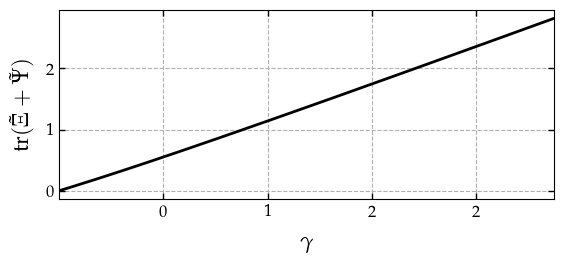

In [12]:
fig = plt.figure(figsize=(6, 3), layout='constrained')
axs = fig.subplot_mosaic([["opt"]])

res_array = np.array(opt_prob_results)

X = res_array[:, 0]
Z_trace = res_array[:, 3]

plot_cfg = {
    'style': {
        'color': 'black'
    },
    'limits': {
        'x_min': X[0],
        'x_max': X[-1],
    },
    'axis': {
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'x_digits': 0,
        'y_digits': 0,
    }
}


gph.plot(axs[f'opt'], X, Z_trace,
         xlabel='$\gamma$', ylabel='tr$(\\tilde \\Xi + \\tilde \\Psi)$', plot_cfg=plot_cfg)
plt.tight_layout(pad=2.)

In [13]:
%%skip

%matplotlib qt

res_array = np.array(opt_prob_results)

# Definir os dados
X = res_array[:, 0]
Y = res_array[:, 1]
Z_beta = res_array[:, 2]
Z_trace = res_array[:, 3] - res_array[:, 2]

# Definir os limites desejados para X e Y
x_min, x_max = 0., 1000

# Definir os rótulos dos gráficos
labels_beta = ['$\\gamma$', '$\\varrho$', '$\\beta$']
labels_trace = ['$\\gamma$', '$\\varrho$', 'tr$(\\tilde \\Xi + \\tilde \\Psi)$']

# Gerar os gráficos
gph.plot_2d_projection(X, Y, Z_beta, x_min=x_min, x_max=x_max,
                       labels=labels_beta)
gph.plot_2d_projection(X, Y, Z_trace, x_min=x_min, x_max=x_max,
                       labels=labels_trace)

In [14]:
δ = 1e-4
h = .2
λ = 1e-2

gamma_bound = 4
rho_bound = 1e-2

design_results = get_parameter(h=h, λ=λ, delta=δ, params=params,
                               epsilon_bounds=[gamma_bound, rho_bound], eps=1e-6)

Ξ = None
Ψ = None
K = None
P = None
M = None
S = None
Q = None
R = None
ρ = None
γ = None
β = None

if design_results is not None:
  Ξ = design_results['etm']['Ξ']
  Ψ = design_results['etm']['Ψ']
  K = design_results['controller']['K']
  P = design_results['lyapunov']['P']
  M = design_results['lyapunov']['M']
  S = design_results['lyapunov']['S']
  Q = design_results['lyapunov']['Q']
  R = design_results['lyapunov']['R']
  ρ = design_results['bounds']['ρ']
  β = design_results['bounds']['β']
  γ = design_results['bounds']['γ']

  print('Resultados:')
  display(Math(rf'f^\star =' + tex.dec2tex(design_results['optimal_value'])))
  # display(Math(rf'\beta =' + tex.dec2tex(β)))
  # display(Math(rf'\rho =' + tex.dec2tex(ρ)))
  display(Math(rf'\gamma^{{-1}} =' + tex.dec2tex(1. / γ)))
  # display(Math(rf'x^\top(t) P x(t) \preceq' + tex.dec2tex(1. / β)))

  # display(Math(rf'P = ' + dp.mat2tex(P)))

  print('Matrizes de Acionamento:')
  display(Math(rf'\Xi = ' + tex.mat2tex(Ξ)))
  display(Math(rf'\Psi = ' + tex.mat2tex(Ψ)))

  print('Matrizes de Controle:')
  B1 = list(itertools.product([0, 1], repeat=1))
  display(Math(rf'K = ' + tex.mat2tex(K)))
else:
  print('Problema não é factível!')

Resultados:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrizes de Acionamento:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrizes de Controle:


<IPython.core.display.Math object>

In [15]:
# %matplotlib inline

# # Definindo intervalo de plotagem
# x1_range = (-15, 15)
# x2_range = (-7.5, 7.5)
# num_points = 20

# aq = nm.get_vertices(x_bounds)

# # Supondo que nm.get_polyhedral_set(a_q, x_bounds) já tenha sido calculado
# # intersection_points = nm.get_polyhedral_set(aq, x_bounds)['intersection_points']

# # Iniciando a figura para o gráfico
# fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# # # Verifica se há pontos de interseção
# # if intersection_points.size > 0:
# #     try:
# #         # Calcula o ConvexHull dos pontos de interseção
# #         hull = ConvexHull(intersection_points)

# #         # Plota as bordas (arestas) do poliedro
# #         for simplex in hull.simplices:
# #             ax.plot(intersection_points[simplex, 0], intersection_points[simplex, 1], 'k-', alpha=0.6)
# #     except:
# #         print("Unable to compute ConvexHull or plot the polyhedron edges.")

# initial_states_list = nm.ellipsoid_boundary_points(P, (1. / β),
#                                                    num_points)
# plt.plot(initial_states_list[0], initial_states_list[1], '*',
#          linestyle='None', c='black', markersize=12)

# # D0 = nm.get_ellipsoid_boundary(P, (1. / β))
# # plt.plot(D0['x1_vals'], D0['x2_vals'],
# #          'k-', label='Ellipsoid Boundary')

# # Função V
# def compute_V(X1, X2, P, M, S, Q, h):
#     V_values = np.zeros_like(X1)
#     for i in range(X1.shape[0]):
#         for j in range(X1.shape[1]):
#             x = np.array([X1[i, j], X2[i, j]])
#             ξ = np.hstack((x, h * x))
#             Pcal = np.block([[P, M], [M.T, S]])
#             V1 = ξ.T @ Pcal @ ξ

#             integral_1 = h * x.T @ Q @ x
#             integral_2 = ((h ** 3) / 2.) * x.T @ R @ x

#             V2 = integral_1 + integral_2
#             V_values[i, j] = V1 + V2
#     return V_values

# X1, X2, V_values, contour_data = nm.get_region_boundary(
#     lambda X1, X2: compute_V(X1, X2, P, M, S, Q, h),
#     x1_range=x1_range, x2_range=x2_range, num_points=100
# )

# δ = 1. / 10000
# μ_inv = (1. / β) + (1. / δ) * (1. / γ)
# print(f'μ_inv = %.3e' % μ_inv)

# plt.contour(X1, X2, V_values, levels=[μ_inv],
#             colors='black', linestyles='--')

# # Ajustes finais de layout
# ax.set_title("Regions")
# ax.set_xlabel("$x_1$")
# ax.set_ylabel("$x_2$")
# ax.grid(True)
# # ax.axis('equal')

# # Exibir o gráfico
# plt.tight_layout()

In [16]:
class DynamicETM:
  def __init__(self, name, Ψ, Ξ, θ, λ, T):
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.next_sampling_time = 0.
    self.last_time = 0.
    self.last_sampled_states = []
    self.last_printed_sampling_time = -1.

    # Matrizes de Acionamento
    self.Ξ = Ξ
    self.Ψ = Ψ
    self.T = T

    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=['n'],
        inputs=['x1_hat', 'x2_hat', 'x1', 'x2'],
        outputs=['n', 'x1', 'x2']
    )

  def etm_update(self, t, n, u, params):
    # Obtenção do último estado transmitido e o estado atual
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)

    # Verifica se ocorrerá um novo evento de transmissão
    new_event = False
    is_sampling_instant = False
    if t >= self.next_sampling_time:
      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = n[0] + self.θ * Tcal < 0
      is_sampling_instant = True

    # Obtenção do x(t - τ)
    xτ = self.last_sampled_states  # Para t != nh
    if is_sampling_instant:
      xτ = x.copy()                # Para t == nh

    # Verifica a atualização de x_hat e ε
    ε = x_hat - xτ
    if new_event == True or t == 0.:
      x_hat = x.copy()
      ε = np.zeros((2, 1))

    # Atualiza a variável dinâmica
    Tcal = xτ.T @ self.Ψ @ xτ - ε.T @ self.Ξ @ ε
    n_dot = - self.λ * n + Tcal

    return n_dot

  def etm_output(self, t, n, u, params):
    if t != self.previous_time:
      if self.previous_time >= self.next_sampling_time:
        self.next_sampling_time += self.T

      if self.first_simulation and t == 0.:
        self.first_simulation = False
        self.previous_time = 0
        self.last_printed_sampling_time = -1.

      if t == 0.:
        self.last_time = 0.
        self.next_sampling_time = 0.
      elif t < self.previous_time:
        assert 'Integração Retrógrada'

      self.previous_time = t

    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)
    new_event = False

    if (t >= self.next_sampling_time):
      if (t != self.last_printed_sampling_time):
        # print(f'Sampling Time: {t:.3f}')
        self.last_printed_sampling_time = t

      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = (n[0] + self.θ * Tcal < 0.) or (t == 0.)
      self.last_sampled_states = x

    if self.first_simulation and new_event and self.event_times[-1] != t:
      # print('Event Time: ', t)
      self.event_times.append(t)

    x_to_send = x if new_event else x_hat

    return np.concatenate((n, x_to_send.reshape(-1)))

In [17]:
class ZeroOrderHold:
  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_samples_sent = [0., 0.]
    self.system = ct.nlsys(
        None, self.zoh_output,
        name='zoh',
        inputs=['x1', 'x2'],
        outputs=['x1_hat', 'x2_hat'],
    )

  def zoh_output(self, t, x, u, params):
    if t != self.previous_time:
      self.last_samples_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_samples_sent


class Controller:
  def __init__(self, K):
    self.K = K
    self.system = ct.nlsys(
        None, self.control_output,
        name='controller',
        inputs=['x1_hat', 'x2_hat',],
        outputs=['u1'],
    )

  def control_output(self, t, x, u, params):
    x_hat = u.reshape(-1, 1)
    return K @ x_hat

In [19]:
# Nome do arquivo de experimento
experiment_name = "Results/DPETC for Linear System under Disturbance/Trajectories-N2.json"
λ = 1e-5
# Define se as simulações devem ser forçadas mesmo se o arquivo já existir
force_simulation = False
simulations_amount = 1

# Estrutura para armazenar os resultados
results_clsim = {
    'trajectories': [],
    'inter-event-times': []
}

# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    results_clsim = json.load(f)
else:
  def get_trajectories(i):
    θ = (1. / λ) * (np.exp(λ * h) - 1.)

    etm = DynamicETM('etm', Ψ, Ξ, θ, λ, h)
    zoh = ZeroOrderHold()
    controller = Controller(K)

    closed_loop = ct.interconnect(
        (plant, etm.system, zoh.system, controller.system),
        connections=[
            ['plant.Qg', 'controller.u1'],

            ['etm.x1_hat', 'zoh.x1_hat'],
            ['etm.x2_hat', 'zoh.x2_hat'],

            ['etm.x1', 'plant.Θw'],
            ['etm.x2', 'plant.Θz'],

            ['zoh.x1', 'etm.x1'],
            ['zoh.x2', 'etm.x2'],

            ['controller.x1_hat', 'zoh.x1_hat'],
            ['controller.x2_hat', 'zoh.x2_hat'],
        ],
        name='closed-loop system',
        inplist=['plant.θ0', 'plant.Qs'],
        outlist=['etm.n', 'plant.Θw', 'plant.Θz', 'controller.u1'],
    )

    etm.event_times = [0.]

    _, trajectories = ct.input_output_response(
        sys=closed_loop, T=timepts,
        U=[θ0, Qs],
        # X0=[initial_states_list[0][i], initial_states_list[1][i], 0.],
        X0=[0., 0., 0.],
        params=params,
        solve_ivp_method='RK45',
        solve_ivp_kwargs={'max_step': simulation_step,
                          'first_step': simulation_step,
                          'atol': 1e-2, 'rtol': 1e-2},
    )

    inter_event_times = np.diff(etm.event_times).tolist()

    return {'trajectories': trajectories.tolist(), 'inter-event-times': inter_event_times}

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim, f, indent=4)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

O arquivo Results/DPETC for Linear System under Disturbance/Trajectories-N2.json já existe. Carregando dados salvos.


In [20]:
# B1 = nm.binary_set(1)
# u_max = u_bar[0]

# x_vals = np.linspace(-.5, .5, 200)
# y_vals = np.linspace(-1, 1, 200)

# X, Y = np.meshgrid(x_vals, y_vals)
# points = np.vstack([X.ravel(), Y.ravel()]).T

# valid_points = np.ones(X.shape, dtype=bool)

# for b in B1:
#   K_b = K[b]
#   G_b = G[b]
#   K_minus_G = K_b - G_b
#   result = np.abs(np.dot(points, K_minus_G.T))
#   valid_points &= (result.reshape(X.shape) <= u_max)

In [21]:
# %matplotlib inline

# x1_range = (-.5, .5)
# x2_range = (-.5, .5)

# trajectories = results_clsim['trajectories']

# fig, ax = plt.subplots(1, 1, figsize=(6., 6.))
# fig.canvas.manager.set_window_title(
#     "Região de Estabilidade Externa/Estados Iniciais Admissíveis")

# ax.contour(X1, X2, V_values, levels=[1. / β],
#             colors='black', linestyles='--')


# for trajectory in trajectories:
#   ax.plot(trajectory[1], trajectory[2], color='black', linestyle=':')

# # contour = ax.contour(X, Y, valid_points,
# #                      colors='#363636', linewidths=1.)

# # ax.plot(initial_states_list[0], initial_states_list[1], '*',
# #          linestyle='None', c='black', markersize=10)

# # ax.set_xlabel("$x_1$", fontsize=14)
# # ax.set_ylabel("$x_2$", fontsize=14, labelpad=0.)
# # ax.tick_params(axis='both', direction='in', length=4, width=1,
# #                colors='black', top=True, right=True, labelsize=14)
# # ax.grid(True, linestyle='--', alpha=0.6)


# # elements = [
# #     ('line', {'color': '#363636', 'linestyle': '-', 'linewidth': 1.}),
# #     ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
# #     ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
# #     ('marker', {'marker': '*', 'color': 'red', 'markersize': 10})
# # ]

# # labels = ['${\\cal D}_u$', '${\\cal D}_x$',
# #           'Trajetórias', 'Pontos Iniciais']

# # gph.create_custom_legend(ax, elements, labels)

# plt.tight_layout()

In [24]:
%matplotlib qt

fig, axs = plt.subplot_mosaic([['η'], ['sat'], ['x'], ['iet']], 
                              figsize=(6, 14))

trajectories = results_clsim['trajectories']
trajectories_index = 0

inter_event_times = results_clsim['inter-event-times'][trajectories_index]
event_times = np.cumsum(inter_event_times)

print("Initial States: ", trajectories[trajectories_index][2][0])
print("Number of Triggered Events: ", len(inter_event_times))
print("Minimum IET Obtained: ", min(inter_event_times))
print("Maximum IET Obtained: ", max(inter_event_times))
print("Average Time Between Events: ", np.mean(inter_event_times))

plot_cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 8, 'y_digits': 0, 'x_digits': 0,
            'x_label_fontsize': 12,
            'y_label_fontsize': 12,
            'tick_fontsize': 12,},
  'limits': { 'x_min': 0.0, 'x_max': simulation_time }
}

gph.plot(
    axs['η'], t, trajectories[trajectories_index][0],
    xlabel='Time [s]', ylabel='$\\eta(t)$',
    title='ETM Dynamic Variable',
    plot_cfg=plot_cfg)

# axs['sat'].hlines([1., -1], 0, 5, colors='black', linestyles='--', label='$|\\bar u(t)|$')
# axs['sat'].legend(prop={'size': 16})

gph.plot(
    axs['sat'], t, 
    [v * 1e-4 for v in trajectories[trajectories_index][3]],
    xlabel='Time [s]', ylabel='$Q_g$ [kW]',
    title='Control Signal - Heat Flow', plot_cfg=plot_cfg)

gph.plot(
    axs['x'],
    t, trajectories[trajectories_index][2],
    xlabel='Time [s]', ylabel=r'$\theta_z$ [ºC]',
    title='Output - Internal Air Temperature',
    plot_cfg=plot_cfg)

gph.stem(
     axs['iet'], [et for et in event_times],
    [et for et in inter_event_times],
    stem_cfg=plot_cfg,
    xlabel='Time [s]', ylabel='$t_{k+1} - t_k$ ($s$)',
    title='Inter-event Times')

plt.tight_layout(pad=3.)

Initial States:  0.0
Number of Triggered Events:  63
Minimum IET Obtained:  0.20000000000000015
Maximum IET Obtained:  40.000000000190994
Average Time Between Events:  3.9460317460448087


In [23]:
import concurrent.futures
import numpy as np
import control as ct
import os
import json
import itertools
import pandas as pd

# Nome do arquivo de experimento

experiment_name = "Results/DPETC for Linear System under Disturbance/ETMParameters-N2.json"

# Definição dos parâmetros
upsilon_values = [1e-2, 1e0, 1e2]
theta_values = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Gerar combinações de upsilon e theta
upsilon_theta_pairs = list(itertools.product(upsilon_values, theta_values))

# Estrutura para armazenar os resultados
results_clsim_etm = {
    'upsilon_theta': [],
    'inter-event-times': [],
    'experiment_parameters': {
        'upsilon_values': upsilon_values,
        'theta_values': theta_values,
        'upsilon_theta_pairs': upsilon_theta_pairs,
    }
}

# Função para obter trajetórias


def get_trajectories(args):
  upsilon, theta = args
  etm = DynamicETM('etm', Ψ, Ξ, theta, upsilon, h)
  zoh = ZeroOrderHold()
  controller = Controller(K)

  closed_loop = ct.interconnect(
      (plant, etm.system, zoh.system, controller.system),
      connections=[
          ['plant.Qg', 'controller.u1'],

          ['etm.x1_hat', 'zoh.x1_hat'],
          ['etm.x2_hat', 'zoh.x2_hat'],

          ['etm.x1', 'plant.Θw'],
          ['etm.x2', 'plant.Θz'],

          ['zoh.x1', 'etm.x1'],
          ['zoh.x2', 'etm.x2'],

          ['controller.x1_hat', 'zoh.x1_hat'],
          ['controller.x2_hat', 'zoh.x2_hat'],
      ],
      name='closed-loop system',
      inplist=['plant.θ0', 'plant.Qs'],
      outlist=['etm.n', 'plant.Θz', 'controller.u1'],
  )

  etm.event_times = [0.]

  _, trajectories = ct.input_output_response(
      sys=closed_loop, T=timepts,
      U=[θ0, Qs],
      # X0=[initial_states_list[0][i], initial_states_list[1][i], 0.],
      X0=[0., 0., 0.],
      params=params,
      solve_ivp_method='RK45',
      solve_ivp_kwargs={'max_step': simulation_step,
                        'first_step': simulation_step,
                        'atol': 1e-2, 'rtol': 1e-2},
  )

  inter_event_times = np.diff(etm.event_times).tolist()
  avg_inter_event_time = np.mean(
      inter_event_times) if inter_event_times else 0

  return {'upsilon': upsilon, 'theta': theta, 'avg_inter_event_time': avg_inter_event_time}


# Verificar se o arquivo já existe
if os.path.exists(experiment_name):
  with open(experiment_name, "r") as f:
    results_clsim_etm = json.load(f)
else:
  # Executar experimentos se o arquivo não existir
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories, upsilon_theta_pairs))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim_etm['upsilon_theta'].append(
        (res['upsilon'], res['theta']))
    results_clsim_etm['inter-event-times'].append(
        res['avg_inter_event_time'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim_etm, f, indent=4)

# print(results_clsim_etm)

# Criar DataFrame com colunas separadas para upsilon e theta
df = pd.DataFrame({
    'upsilon_theta': results_clsim_etm['upsilon_theta'],
    'inter-event-times': results_clsim_etm['inter-event-times']
})

# Separar as colunas de upsilon e theta
df[['upsilon', 'theta']] = pd.DataFrame(
    df['upsilon_theta'].tolist(), index=df.index)

# Criar tabela pivotada com upsilon nas colunas e theta nas linhas
pivot_df = df.pivot(index='theta', columns='upsilon',
                    values='inter-event-times')

# Exibir a tabela
print(pivot_df)

upsilon    0.01      1.00      100.00
theta                                
0.01     2.501075  3.507042  4.901961
0.10     2.729670  3.926984  4.581481
1.00     4.305455  5.628571  4.930612
10.00    6.982857  4.321429  4.930612
100.00   6.268421  4.930612  4.930612


upsilon    0.01      1.00      100.00
theta                                
0.01     0.473992  0.470433  0.561629
0.10     0.585915  0.556437  0.530472
1.00     0.561528  0.547046  0.530701
10.00    0.492150  0.544488  0.521837
100.00   0.489666  0.532623  0.521837